## Cats and Dogs (1/3)
### Building powerful image classification models using very little data
By Francois Chollet: 
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

Este é o primeiro de 3 experimentos que ilustram a importância da transferência de conhecimento (*transfer learning*), isto é, utilizar pesos de redes já treinadas em outras aplicações.

Utiliza-se aqui uma rede convolucional com mais de 1 milhão de parâmetros a serem treinados. O treinamento é feito de uma rede com inicialização padrão do Keras.

Este notebook ilustra também a técnica de *data augmentation*.

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'theano'
os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=cpu,floatX=float32'

In [2]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import sys
import numpy as np
import numpy.random as nr

import theano
import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

print 'Keras ', keras.__version__
print 'Theano', theano.__version__


Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Keras  1.2.0
Theano 0.8.2


## Dataset

O dataset foi obtido de uma competição do Kaggle, https://www.kaggle.com/c/dogs-vs-cats/data.
Utilizaremos neste exemplo as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    CatsDogs/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

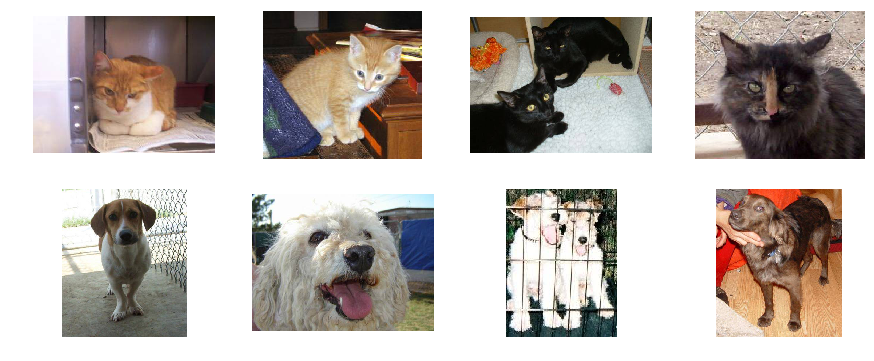

In [13]:
train_data_dir = '/root/CatsDogs/train'
validation_data_dir = '/root/CatsDogs/validation'
nb_train_samples = 2000
nb_validation_samples = 800

N = 4
image_filenames = []
fig = plot.figure(figsize=(15,6))
for i, j in enumerate(nr.randint(0, 1000, N)):
    fig.add_subplot(2, N, i+1)
    fn = '{}/cats/cat.{}.jpg'.format(train_data_dir, j)
    img = plot.imread(fn)
    plot.imshow(img)
    plot.axis('off')
    image_filenames.append(fn)
    
    fig.add_subplot(2, N, i+N+1)
    fn = '{}/dogs/dog.{}.jpg'.format(train_data_dir, j)
    img = plot.imread(fn)
    plot.imshow(img)    
    plot.axis('off')
    image_filenames.append(fn)


## Aumentando o dataset

In [14]:
# dimensions of our images.
img_width, img_height = 150, 150

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

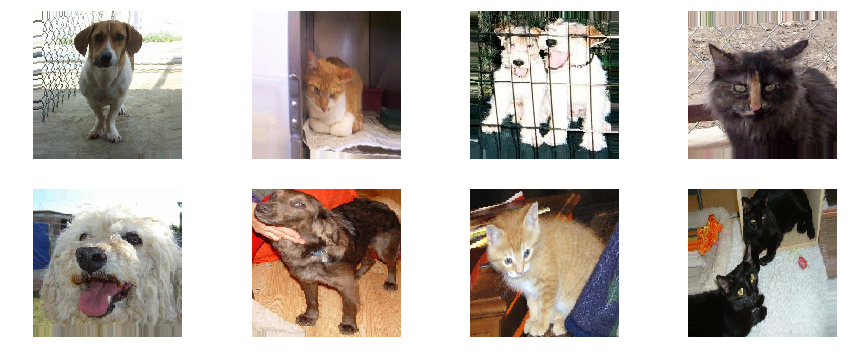

In [15]:
X_s = np.empty((2*N, 3, 150, 150), np.uint8)
y_s = np.empty((2*N,), np.int32)
for i, fn in enumerate(image_filenames):
    y_s[i] = 1 if fn.split('/')[-2] == 'dogs' else 0
    img = load_img(fn, grayscale=False, target_size=(150, 150))
    X_s[i] = img_to_array(img, dim_ordering='th')

generator = train_datagen.flow(X_s, y_s, batch_size=8)
    
X, y = generator.next()

fig = plot.figure(figsize=(15,6))
for i, arr in enumerate(X):
    img = arr.transpose(1, 2, 0)
    fig.add_subplot(2, 4, i+1)
    plot.imshow(img)
    plot.axis('off')
    

In [16]:
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Classificador
A rede neural utilizada é especificada a seguir.

In [18]:
class LeNet:
    @staticmethod
    def build(img_width, img_height):
        model = Sequential()
        model.add(Convolution2D(32, 3, 3, input_shape=(3, img_height, img_width)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Convolution2D(32, 3, 3))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Convolution2D(64, 3, 3))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation('relu'))

        model.add(Dropout(0.5))

        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        
        return model

LeNet.build(img_width, img_height).summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 32, 148, 148)  896         convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 32, 148, 148)  0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 32, 74, 74)    0           activation_6[0][0]               
____________________________________________________________________________________________________
convolution2d_5 (Convolution2D)  (None, 32, 72, 72)    9248        maxpooling2d_4[0][0]             
___________________________________________________________________________________________

In [19]:
os.sys.path.append('../src/')
from my_keras_utilities import (load_model_and_history, 
                                TrainingPlotter)

model_name = '../../models/cats_dogs_1'

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = LeNet.build(img_width, img_height)
    
    # History, checkpoint, earlystop, plot losses:
    histo = TrainingPlotter(n=1, filepath=model_name, patience=10)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, histo = load_model_and_history(model_name)


[INFO] loading model...


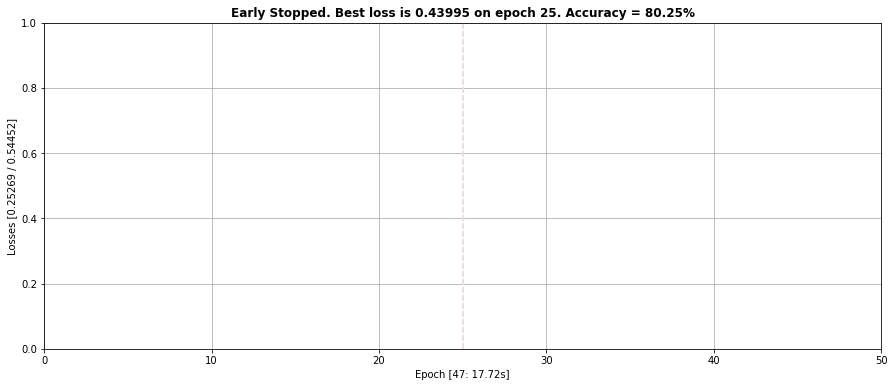

In [21]:
nb_epoch = 50
ploss = 1.0

nepochs = nb_epoch - histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, ploss)
plot.xlim(0, nb_epoch)
plot.grid(True)

if nepochs > 0:
    print("[INFO] training...")
    try:
        model.fit_generator(
            train_generator,
            samples_per_epoch=nb_train_samples,
            nb_epoch=nepochs,
            validation_data=validation_generator,
            nb_val_samples=nb_validation_samples,
            verbose=0,
            callbacks=[histo],
        )
    except KeyboardInterrupt:
        pass
else:
    print("[INFO] plotting...")
    

In [22]:
print("[INFO] loading model...")
model, histo = load_model_and_history(model_name)
print("[INFO] evaluating...")
loss, accuracy = model.evaluate_generator(validation_generator, nb_validation_samples)
print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))


[INFO] loading model...
[INFO] evaluating...
[INFO] accuracy: 80.25%


## Aprendizados com este notebook

- DataGenerator cria variações da base original que criam um conjunto contínuo de dados que podem ser usados para treinamento aumentando o número de amostras e melhoram a generalidade do classificador.
